In [106]:
import tensorflow as tf
from tensorflow import keras

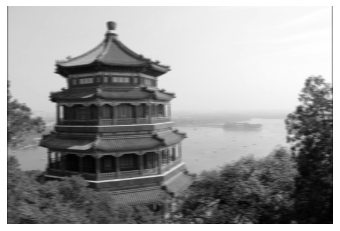

In [107]:
import numpy as np
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray")
plt.axis("off")
plt.show()

In [108]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

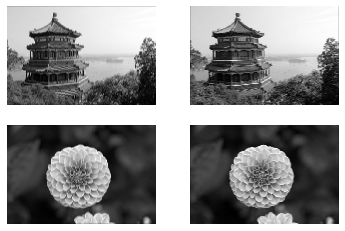

In [109]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

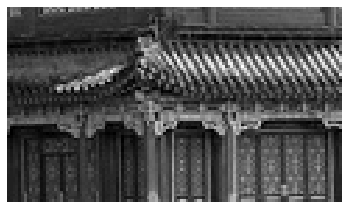

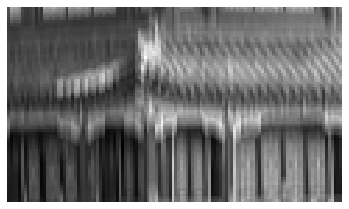

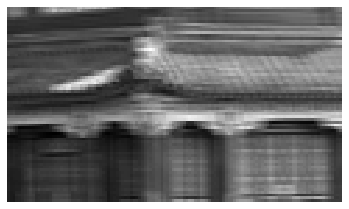

In [110]:
def crop(image):
    return image[150:220, 130:250]

plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

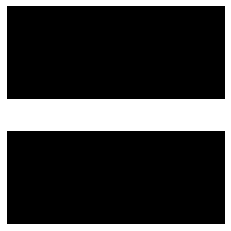

In [111]:
plot_image(filters[:, :, 0, 1])

In [112]:
conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1, padding="same", activation="relu", input_shape=outputs.shape)
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

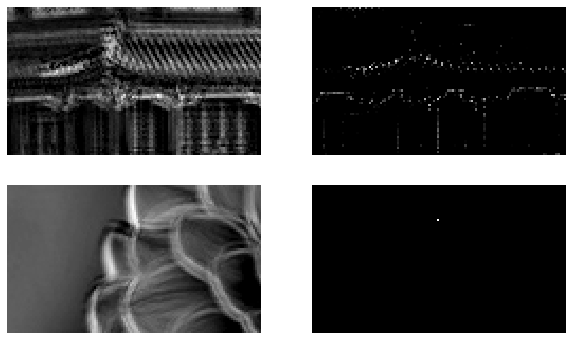

In [113]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

In [114]:
conv.set_weights([filters, np.zeros(2)])

In [115]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

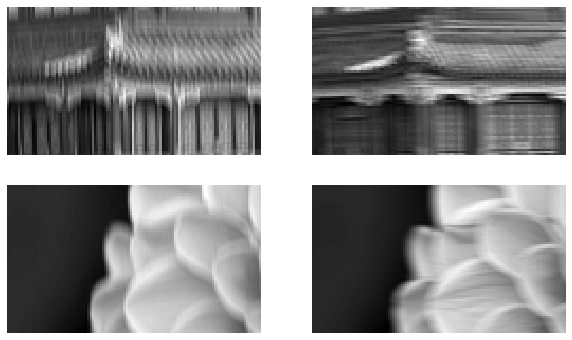

In [116]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

In [117]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [118]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

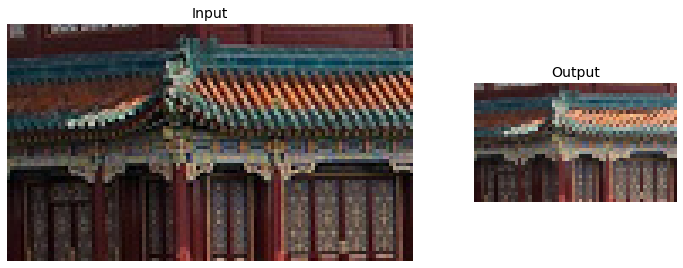

In [119]:
import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])
ax2.axis("off")
plt.show()

In [120]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    
    def call(self, inputs):
        return tf.nn.max_pool(inputs, ksize=(1, 1, 1, self.pool_size), strides=(1, 1, 1, self.pool_size), padding=self.padding)

In [121]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [122]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

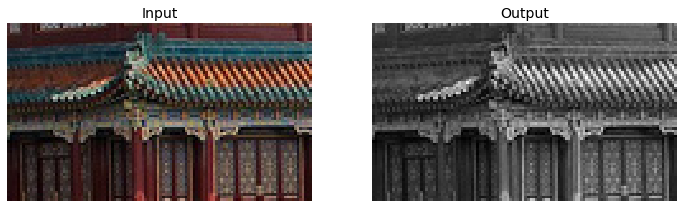

In [123]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])
plt.axis("off")
plt.show()

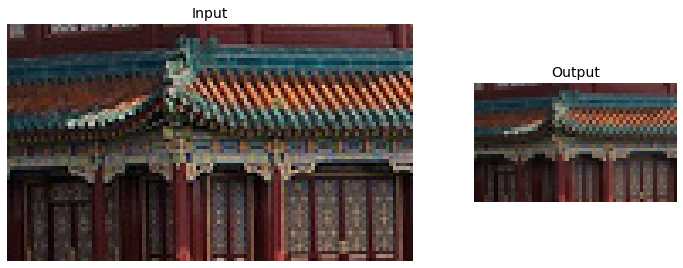

In [124]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])
ax2.axis("off")
plt.show()

In [125]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.45952484, 0.3342377 ]], dtype=float32)>

In [126]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [127]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation="relu", padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax"),
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[np.random.randint(0,10):np.random.randint(10,20)]
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 162s 94ms/step - loss: 0.7050 - accuracy: 0.7569 - val_loss: 0.3669 - val_accuracy: 0.8692
Epoch 2/10
1719/1719 [==============================] - 163s 95ms/step - loss: 0.4093 - accuracy: 0.8627 - val_loss: 0.3156 - val_accuracy: 0.8864
Epoch 3/10
1719/1719 [==============================] - 162s 94ms/step - loss: 0.3621 - accuracy: 0.8790 - val_loss: 0.3073 - val_accuracy: 0.8914
Epoch 4/10
1719/1719 [==============================] - 162s 95ms/step - loss: 0.3264 - accuracy: 0.8901 - val_loss: 0.2903 - val_accuracy: 0.8964
Epoch 5/10
1719/1719 [==============================] - 163s 95ms/step - loss: 0.3055 - accuracy: 0.8973 - val_loss: 0.2967 - val_accuracy: 0.8944
Epoch 6/10
1719/1719 [==============================] - 162s 94ms/step - loss: 0.2861 - accuracy: 0.9037 - val_loss: 0.2864 - val_accuracy: 0.9010
Epoch 7/10
1719/1719 [==============================] - 160s 93ms/step - loss: 0.2695 - accuracy: 0.9065 - val_loss: 0

In [129]:
print(score)
print(y_pred)

[0.3084871470928192, 0.8924000263214111]
[[2.07431194e-30 3.90678030e-36 1.78195081e-31 2.60803367e-35
  8.46275519e-35 1.00000000e+00 1.06871432e-29 6.89239499e-10
  7.78185448e-25 3.15141246e-10]
 [2.65977498e-28 0.00000000e+00 4.36812231e-32 3.99665324e-34
  2.44714196e-28 8.24004758e-08 7.68783779e-27 9.99999523e-01
  2.34492350e-22 3.05869520e-07]
 [5.96241643e-13 3.42197821e-19 1.51207889e-04 7.06749709e-13
  9.99641538e-01 3.76241212e-33 2.07216857e-04 5.61648492e-34
  2.94191722e-19 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 6.48901891e-19
  0.00000000e+00 2.16317643e-19]
 [4.65002126e-09 6.36046879e-13 1.83899884e-09 9.50923854e-11
  2.11581188e-08 9.71278250e-02 1.43984549e-08 8.99596810e-01
  3.68516089e-06 3.27159464e-03]
 [1.03493845e-11 1.03499600e-14 2.05470372e-21 1.00000000e+00
  1.61307803e-14 0.00000000e+00 4.95866181e-10 0.00000000e+00
  1.56991566e-25 0.00000000e+00]
 [7.51293044e-07 

In [130]:
# keras.backend.clear_session()

In [134]:
# (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
# X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
# y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# LeNet-5

model = keras.models.Sequential()
model.add(keras.layers.ZeroPadding2D(padding=2, input_shape=[28, 28, 1]))
model.add(keras.layers.Conv2D(6, kernel_size=5, strides=1, activation="tanh"))
model.add(keras.layers.MaxPooling2D(2, strides=2))
model.add(keras.layers.Conv2D(16, kernel_size=5, strides=1, activation="tanh"))
model.add(keras.layers.MaxPooling2D(2, strides=2))
model.add(keras.layers.Conv2D(120, kernel_size=5, strides=1, activation="tanh"))
model.add(keras.layers.Dense(84, activation="tanh"))
model.add(keras.layers.Dense(10, activation="softmax"))     # rbf? -> softmax

In [135]:
# AlexNet

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(96, kernel_size=11, strides=4, padding="VALID", activation="relu", input_shape=[227, 227, 3]))
model.add(keras.layers.MaxPooling2D(3, strides=2, padding="VALID"))
model.add(keras.layers.Conv2D(256, kernel_size=5, strides=1, padding="SAME", activation="relu"))
model.add(keras.layers.MaxPooling2D(3, strides=2, padding="VALID"))
model.add(keras.layers.Conv2D(384, kernel_size=3, strides=1, padding="SAME", activation="relu"))
model.add(keras.layers.Conv2D(384, kernel_size=3, strides=1, padding="SAME", activation="relu"))
model.add(keras.layers.Conv2D(256, kernel_size=3, strides=1, padding="SAME", activation="relu"))
model.add(keras.layers.MaxPooling2D(3, strides=2, padding="VALID"))
model.add(keras.layers.Dense(4096, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4096, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1000, activation="softmax"))